# Machine learning with TensorFlow: CNN

Date: November 5, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:
- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_FOLDER = '/content/gdrive/My Drive/acoustic_event_detection/data/'
FILTERS=40
TRAINING_FILES = 67
FILES = 100

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os

## Preparing data set for training CNN

In [0]:
import glob
piano_files = glob.glob(DATA_FOLDER+'*piano*mel_spectrogram*.csv')
classical_guitar_files = glob.glob(DATA_FOLDER+'*classical_guitar*mel_spectrogram*.csv')
framenco_guitar_files = glob.glob(DATA_FOLDER+'*framenco_guitar*mel_spectrogram*.csv')
blues_harp_files = glob.glob(DATA_FOLDER+'*blues_harp*mel_spectrogram*.csv')
tin_whistle_files = glob.glob(DATA_FOLDER+'*tin_whistle*mel_spectrogram*.csv')

random.shuffle(piano_files)
random.shuffle(classical_guitar_files)
random.shuffle(framenco_guitar_files)
random.shuffle(blues_harp_files)
random.shuffle(tin_whistle_files)

In [0]:
TRAINING_SET_PIANO = piano_files[:TRAINING_FILES]
TRAINING_SET_CLASSICAL_GUITAR = classical_guitar_files[:TRAINING_FILES]
TRAINING_SET_FRAMENCO_GUITAR = framenco_guitar_files[:TRAINING_FILES]
TRAINING_SET_BLUES_HARP = blues_harp_files[:TRAINING_FILES]
TRAINING_SET_TIN_WHISTLE = tin_whistle_files[:TRAINING_FILES]

TEST_SET_PIANO = piano_files[TRAINING_FILES:FILES]
TEST_SET_CLASSICAL_GUITAR = classical_guitar_files[TRAINING_FILES:FILES]
TEST_SET_FRAMENCO_GUITAR = framenco_guitar_files[TRAINING_FILES:FILES]
TEST_SET_BLUES_HARP = blues_harp_files[TRAINING_FILES:FILES]
TEST_SET_TIN_WHISTLE = tin_whistle_files[TRAINING_FILES:FILES]

TRAINING_SET = [(TRAINING_SET_PIANO, 0),
                (TRAINING_SET_CLASSICAL_GUITAR, 1),
                (TRAINING_SET_FRAMENCO_GUITAR, 2),
                (TRAINING_SET_BLUES_HARP, 3),
                (TRAINING_SET_TIN_WHISTLE, 4)]

TEST_SET = [(TEST_SET_PIANO, 0),
            (TEST_SET_CLASSICAL_GUITAR, 1),
            (TEST_SET_FRAMENCO_GUITAR, 2),
            (TEST_SET_BLUES_HARP, 3),
            (TEST_SET_TIN_WHISTLE, 4)]

In [0]:
import sklearn.preprocessing as pp

training_set = []
test_set = []

a1, a2 = 0,  FILTERS*64
b1, b2 = FILTERS*64, FILTERS*64*2
c1, c2 = FILTERS*64*2, FILTERS*64*3

def label(l):
    ll = [0,0,0,0,0]
    ll[l] = 1
    return ll

for files, l in TRAINING_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        training_set.append((img1, label(l)))
        training_set.append((img2, label(l)))
        training_set.append((img3, label(l)))
        
for files, l in TEST_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        test_set.append((img1, label(l)))
        test_set.append((img2, label(l)))
        test_set.append((img3, label(l)))
                        
random.shuffle(training_set)
random.shuffle(test_set)

In [0]:
train_x, train_t = [], []
test_x, test_t = [], []
for img, label in training_set:
    train_x.append(img)
    train_t.append(label)
for img, label in test_set:
    test_x.append(img)
    test_t.append(label)

## CNN on TensorFlow

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
np.random.seed(20181105)
tf.set_random_seed(20181105)

### Convolution layer

In [0]:
num_samples = FILTERS * 64
num_classes = 5

num_filters1 = 16
num_filters2 = 32
num_filters3 = 64

num_layers = 1

x = tf.placeholder(tf.float32, [None, FILTERS*64])

x_image = tf.reshape(x, [-1,64,FILTERS,1])

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, num_filters1], stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

W_conv2 = tf.Variable(tf.truncated_normal([5, 5, num_filters1, num_filters2], stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

W_conv3 = tf.Variable(tf.truncated_normal([5, 5, num_filters2, num_filters3], stddev=0.1))
h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1,1,1,1], padding='SAME')
b_conv3 = tf.Variable(tf.constant(0.1, shape=[num_filters3]))
h_conv3_cutoff = tf.nn.relu(h_conv3 + b_conv3)
h_pool3 = tf.nn.max_pool(h_conv3_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

h_pool_flat3 = tf.reshape(h_pool3, [-1, int(FILTERS/2**3)*int(64/2**3)*num_filters3])

### Fully connected layer

In [0]:
num_units1 = int(FILTERS/2**3)*int(64/2**3)*num_filters3
num_units2 = 4096

num_classes = 5

w1 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b1 = tf.Variable(tf.zeros([num_units2]))
y1 = tf.matmul(h_pool_flat3, w1) + b1
hidden1 = tf.nn.relu(y1)

w2 = tf.Variable(tf.truncated_normal([num_units2, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
y2 = tf.matmul(hidden1, w2) + b2
hidden2 = tf.nn.relu(y2)

w3 = tf.Variable(tf.truncated_normal([num_units2, num_units2]))
b3 = tf.Variable(tf.zeros([num_units2]))
y3 = tf.matmul(hidden2, w3) + b3
hidden3 = tf.nn.tanh(y3)

keep_prob = tf.placeholder(tf.float32)
hidden3_drop = tf.nn.dropout(hidden3, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, num_classes]))
b0 = tf.Variable(tf.zeros([num_classes]))
p = tf.nn.softmax(tf.matmul(hidden3_drop, w0) + b0)

In [0]:
t = tf.placeholder(tf.float32, [None, num_classes])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.00003).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [13]:
i = 0
for _ in range(4000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t, keep_prob:0.5})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:test_x, t:test_t, keep_prob:1.0})
        print('Step: {}, Loss: {}, Accuracy: {}'.format(i, loss_val, acc_val))
    if i % 500 == 0:
      saver.save(sess, './aed_cnn_session', global_step=i)

Step: 100, Loss: 461.9782409667969, Accuracy: 0.8060606122016907
Step: 200, Loss: 328.4143371582031, Accuracy: 0.8323232531547546
Step: 300, Loss: 266.01214599609375, Accuracy: 0.8484848737716675
Step: 400, Loss: 231.6869354248047, Accuracy: 0.8666666746139526
Step: 500, Loss: 213.00819396972656, Accuracy: 0.870707094669342
Step: 600, Loss: 195.45726013183594, Accuracy: 0.8787878751754761
Step: 700, Loss: 186.1929168701172, Accuracy: 0.8868687152862549
Step: 800, Loss: 173.95654296875, Accuracy: 0.90505051612854
Step: 900, Loss: 164.54891967773438, Accuracy: 0.9070706963539124
Step: 1000, Loss: 160.22171020507812, Accuracy: 0.9010100960731506
Step: 1100, Loss: 152.27072143554688, Accuracy: 0.9070706963539124
Step: 1200, Loss: 146.75930786132812, Accuracy: 0.8989899158477783
Step: 1300, Loss: 141.76181030273438, Accuracy: 0.8949494957923889
Step: 1400, Loss: 139.5734100341797, Accuracy: 0.8949494957923889
Step: 1500, Loss: 134.34811401367188, Accuracy: 0.9151515364646912
Step: 1600, Los

### Confirmation with test data set

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
p_test = sess.run(p, feed_dict={x:test_x, keep_prob:1.0})
(p_test*112).astype(int)[:16]

array([[ 36,  50,  22,   2,   0],
       [ 46,  16,  30,  15,   2],
       [  1,   0,   0,   0, 110],
       [  0,   0,   0, 111,   0],
       [  0,   0, 105,   6,   0],
       [  0,   0,   0,   0, 111],
       [111,   0,   0,   0,   0],
       [  3, 108,   0,   0,   0],
       [105,   6,   0,   0,   0],
       [  0,   0,   0,   0, 111],
       [ 22,  89,   0,   0,   0],
       [  0,   0,   0, 111,   0],
       [  0,   0,   1, 108,   1],
       [  0,   0,   0, 111,   0],
       [  0,   0, 110,   1,   0],
       [  0,   0,  14,  97,   0]])

In [16]:
test_t[:16]

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0]]

In [0]:
filter_vals, conv_vals = sess.run([W_conv3, h_pool3], feed_dict={x:train_x})

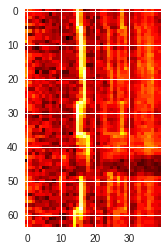

In [18]:
plt.imshow(train_x[10].reshape(64,FILTERS), interpolation='nearest', cmap=plt.cm.hot)

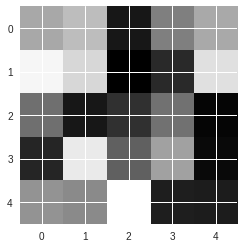

In [19]:
plt.imshow(filter_vals[:,:,0,10], interpolation='nearest', cmap=plt.cm.gray_r)

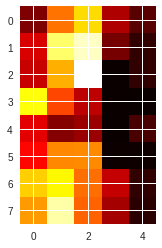

In [20]:
plt.imshow(conv_vals[20,:,:,10], interpolation='nearest', cmap=plt.cm.hot)

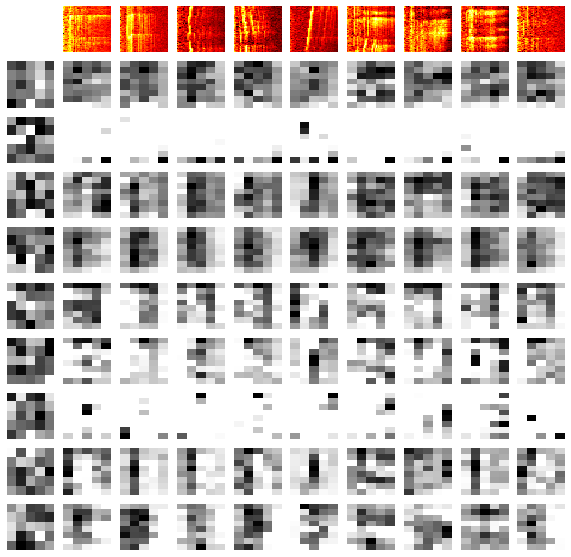

In [21]:
fig = plt.figure(figsize=(10,10))

for j in range(9):
  subplot = fig.add_subplot(10,10,10*(j+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:,:,0,j],cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
  subplot = fig.add_subplot(10,10,i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(train_x[i].reshape(64,FILTERS),cmap=plt.cm.hot, interpolation='nearest', aspect='auto')
    
for j in range(9):
  for i in range(9):
    subplot = fig.add_subplot(10,10,10*(j+1)+2+i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,j],cmap=plt.cm.gray_r, interpolation='nearest', aspect='auto')

fig.savefig(DATA_FOLDER+'/filterd_spectrogram.png')